# Galaxy Properties and Dark Matter Halo
***

The goal of this project is to predict galaxy properties from the properties of the dark matter haloes in which they form. As dark matter haloes cannot be directly observed, this connection is difficult to determine observationally, but can be derived with empirical models. The catalogues below for 10 different redshifts contain different halo properties (e.g. halo mass, peak mass through time, growth rate) that should be used as features, and galaxy properties (e.g. stellar mass and star formation rate) that should be used as labels. They are in the HDF5 format that can be read in python with the h5py or the pandas packages. The following non-exhaustive list contains suggested steps and ideas to achieve reasonable results.<br>
1. Load the table and divide between features and labels
2. Check which features correlate best with the labels
3. Scale the features (depending on the ML algorithms to between 0 and 1)
4. Split the data in training, validation, and test sets
5. Test different ML algorithms. You should use at least 3 commonly used methods, e.g. random forests, SGD, SVM, neural networks
6. Think about feature importance (using random forests)
7. Think about regularization
8. Think about dimensionality reduction (manifold learning)
9. Plot learning curves - when do you stop?
10. Determine the hyperparameters with the validation set
11. What is the final score on the test set for each algorithm?
***

## Reading Datasets
***

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [192]:
pd.options.display.max_rows
pd.set_option("display.max_rows",20)
pd.options.display.max_rows

20

In [193]:
#Reading dataset, Slicing, splitting, and scaling
data_1 = pd.read_hdf("galaxies.Z00.h5").iloc[:,0:9].iloc[:10000, :]
data_1

,Halo_mass,Halo_growth_rate,Halo_mass_peak,Scale_peak_mass,Scale_half_mass,Halo_radius,Concentration,Halo_spin,Stellar_mass
0,11.291506,0.000000,11.933064,0.52,0.26,0.153729,207.948105,0.03063,10.426738
1,11.107182,0.000000,11.269677,0.89,0.49,0.133456,119.950928,0.02274,9.099111
2,10.774375,5.415474,11.231920,0.38,0.30,0.103370,20.775208,0.00583,9.304751
3,9.996202,0.150599,10.529177,0.55,0.47,0.056887,39.662548,0.03998,7.168949
4,9.668787,0.000000,10.674248,0.65,0.26,0.044248,46.062977,0.02509,7.502442
5,10.447030,0.152119,10.585270,0.61,0.32,0.080730,35.526623,0.01161,7.077418
6,10.197127,0.000000,11.126522,0.31,0.25,0.066642,53.510662,0.05172,9.243076
7,10.087936,0.000000,10.844924,0.51,0.27,0.061287,32.989677,0.08682,7.735672
8,9.695172,0.000000,10.578727,0.36,0.20,0.045334,51.462311,0.01582,7.193423
9,9.543894,0.000000,10.437775,0.33,0.28,0.040366,40.288658,0.04155,7.630946


##  A closer look into the features
***

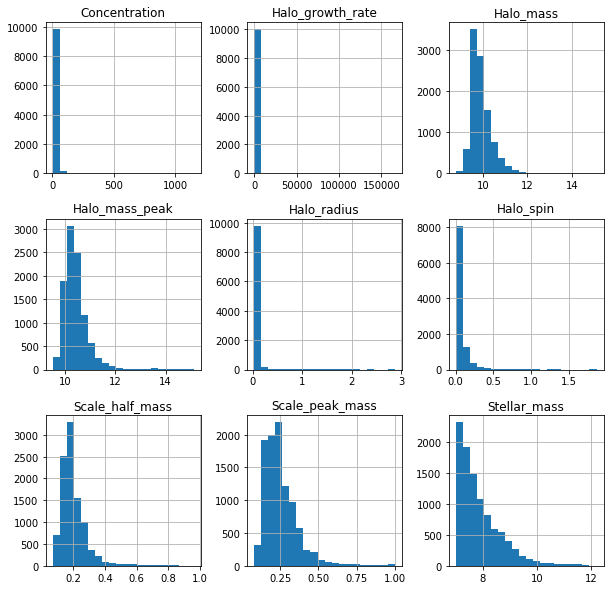

In [163]:
data_1_histograms= data_1.hist(bins=20, figsize=[10,10])

The conclusion that can be drawn from the above histograms is
-  Concentration, Halo_growth_rate, halo_radius, and halo_spin remains approximately constants as stellar mass increase. Hence we expect a small correlation between those features and stellar mass.
-  Consentration, Halo_growth_rate,Halo_radius, halo_spin, scale_peak_mass, and stellar do not follow (approximately) Gaussian distribution, therefore for feature scalling, we will use min-max scaler.
-  Halo_mass, halo_mass_peak and scale_half_mass approximately are distributed according to Gaussian, hence we will use standard scaler for feature scaling
***

## Correlation between Feature and Labels
***

In [164]:
corr_matrix = data_1.corr()
corr_matrix.iloc[:, 8].sort_values()

Halo_spin          -0.169583
Halo_growth_rate    0.128429
Concentration       0.155169
Scale_half_mass     0.243439
Scale_peak_mass     0.285413
Halo_radius         0.516154
Halo_mass           0.746384
Halo_mass_peak      0.842733
Stellar_mass        1.000000
Name: Stellar_mass, dtype: float64

***

## Data Preprocessing
***


In [165]:
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

#splitting feature and label
dataset_1=data_1.copy()
X=dataset_1.drop(["Stellar_mass"], axis=1)
y= dataset_1["Stellar_mass"]

#splitting test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#define a custom transformer class for feature scaling 
class FeatureSelector(TransformerMixin, BaseEstimator):
    def __init__(self, feature_list):
        self.feature_list = feature_list
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_list].values


minmax_feature=["Concentration", "Halo_growth_rate","Halo_radius", "Halo_spin", "Scale_peak_mass" ]
st_feature= ["Halo_mass", "Halo_mass_peak", "Scale_half_mass"] 

#minmax scaling pipleline
minmax_steps= [("mm_selector", FeatureSelector(minmax_feature)),
               ("imputer", Imputer(strategy= "mean")), ("mm_scaler", MinMaxScaler())]
minmax_pipe= Pipeline(minmax_steps)

#standard scaling pipeline
st_steps =  [("st_selector", FeatureSelector(st_feature)),
             ("imputer", Imputer(strategy= "mean")), ("st_scaler", StandardScaler())]
st_pipe=Pipeline(st_steps)

#combined pipeline to concateante output of the above two pipeline
prep_pipe=FeatureUnion([("minmax", minmax_pipe), ("st", st_pipe)])

***

## Regression problem using Random Forest, SVM, SGD
***

In [173]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score


#RF Regression
RF_steps=[("prep", prep_pipe), ("RF", RandomForestRegressor())]
RF_regressor=Pipeline(RF_steps)
CV_score=cross_val_score(RF_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print(f"RMSE CV score of Random forest is {np.mean(CV_score)}")




RMSE CV score of Random forest is -0.055731054935235405


In [174]:
#SV Regression
SV_steps=[("prep", prep_pipe), ("SV", SVR())]
SV_regressor=Pipeline(SV_steps)
CV_score=cross_val_score(SV_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print(f"RMSE CV score of SVM is {np.mean(CV_score)}")


RMSE CV score of SVM is -0.06280872278958362


In [187]:
import warnings
warnings.filterwarnings('ignore')


#SGD Regression
SGD_steps=[("prep", prep_pipe), ("SV", SGDRegressor())]
SGD_regressor=Pipeline(SGD_steps)
CV_score=cross_val_score(SGD_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print(f"RMSE CV score of SGD is {np.mean(CV_score)}")

RMSE CV score of SGD is -0.18570378186261596


        target  RF Prediction  SVR Prediction  SGD Prediction
9394  7.300076       7.513507        7.624021        7.875335
898   8.134915       8.136692        8.796300        8.791017
2398  7.263627       7.306505        7.368963        7.754252
5906  7.257608       7.260084        7.222876        7.016933
2343  8.079779       7.840764        7.939999        7.779820
8225  8.596020       8.822126        8.609036        8.317001
5506  7.428528       7.374510        7.471048        7.496447
6451  7.494291       7.375457        7.422814        7.257120
2670  7.218812       7.213939        7.226451        7.239834
3497  9.967265      10.144886       10.156587        9.618787
...        ...            ...             ...             ...
5581  7.885168       7.941771        8.021562        8.268636
7133  8.218892       8.453353        8.213134        7.918116
4041  7.218858       7.352382        7.277623        7.427181
4807  8.730278       8.368802        8.515618        8.130956
1774  7.

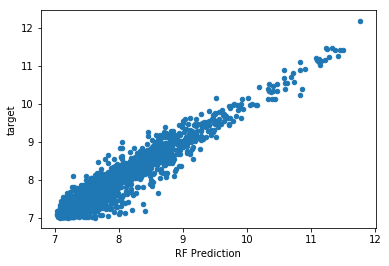

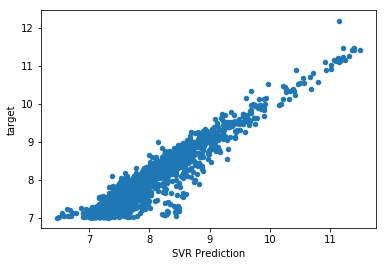

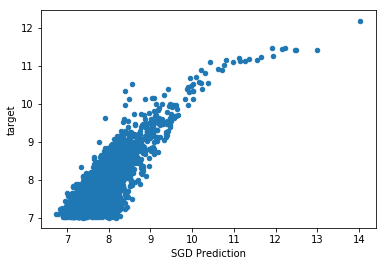

In [197]:
warnings.filterwarnings('ignore')

RF_regressor.fit(X_train, y_train)
SV_regressor.fit(X_train, y_train)
SGD_regressor.fit(X_train, y_train)
report = pd.DataFrame({ "target": y_test, "RF Prediction":RF_regressor.predict(X_test), 
                      "SVR Prediction": SV_regressor.predict(X_test), 
                      "SGD Prediction": SGD_regressor.predict(X_test)})

report.plot.scatter(x="RF Prediction", 
                         y = "target")
report.plot.scatter(x="SVR Prediction", 
                         y = "target")
report.plot.scatter(x="SGD Prediction", 
                         y = "target")


***

20

## Feature Importance 
***
We use two different method to elimintae less correlated features, to avoid curse of dimensionality and fasten computations:
1. 